# Metodología TRIAGE

El triage es un proceso creado por el Observatorio de Desarrollo Económico de Bogotá (ODEB) para optimizar las convocatorias de la oferta institucional de la Secretaría Distrital de Desarrollo Económico (SDDE) y facilitar su evaluación. Para esto, el triage utiliza una base única de unidades productivas de Bogotá y estima un puntaje que organiza las unidades productivas de acuerdo con la posibilidad que estas tienen de beneficiarse del programa. Primero, utiliza el análisis de factores para datos mixtos, una variante de la metodología de componentes principales, para reducir la dimensionalidad de los criterios de los programas que deben cumplir las unidades productivas participantes, posteriormente, agrupa las unidades productivas de acuerdo a esta caracterización simplificada usando la técnica k-means y, por último, genera un puntaje de priorización de acuerdo a la distancia de la unidad productiva al centroide del grupo preferido para recibir el programa. 


*Nota aclaratoria:* Al ejecutar este código en jupyter notebook y a pesar de establecer semillas aleatorias en todas las funciones, los puntajes finales pueden variar levemente, pero el orden de estos puntajes no varía. Por tal razón, se recomienda ejecutar el código desde otro IDE. 

### Definir las rutas de las carpetas

In [1]:
# Se importa la librería para cambiar WD
import os
print(os.getcwd()) # Ver WD antes

# Rutas a las carpetas
root = '/Users/jennyriveraburgos/Library/CloudStorage/GoogleDrive-jrivera.desarrolloeconomico@gmail.com/My Drive/Notebook_Jupyter_TRIAGE/'
code_path = root + os.sep + '0_Code' + os.sep
raw_path = root + os.sep + '1_Raw' + os.sep
temp_path = root + os.sep + '2_Temp' + os.sep
clean_path = root + os.sep + '3_Clean' + os.sep
output_path = root + os.sep + '4_Output' + os.sep

os.chdir(code_path) # Cambia el WD a 0_Code
print(os.getcwd()) # Ver WD después

/Users/jennyriveraburgos/Library/CloudStorage/GoogleDrive-jrivera.desarrolloeconomico@gmail.com/My Drive/Notebook_Jupyter_TRIAGE/0_Code
/Users/jennyriveraburgos/Library/CloudStorage/GoogleDrive-jrivera.desarrolloeconomico@gmail.com/My Drive/Notebook_Jupyter_TRIAGE/0_Code


### Cargar librerías

In [2]:
#Código necesario para instalar librerías
#pip install fontstyle
#pip install prince


# Se importan las librerías externas a usar
import numpy as np
np.random.seed(0)

import pandas as pd
import fontstyle
import matplotlib.pyplot as plt
from prince import FAMD
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn import linear_model
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.impute import SimpleImputer
import re
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf

from IPython.display import Markdown as md


# Se importan los scripts propios a usar
import limpieza_variables as lv
import criterios_programas as cp
import diccionario_variables as dv
import Fun_triage as triage

### Abrir base de Tropa

Se utilizan solo los datos de las unidades productivas que autorizaron el uso de sus datos.

In [3]:
#file_tropa = '20220919 Datos Tropa v1+v2.csv'
#file_tropa = 'Base priorización hasta 21 oct 22.xlsx'
file_tropa = 'df_tropa_muestra.xlsx'


if file_tropa[-5:] == '.xlsx':
    df_tropa = pd.read_excel(raw_path + file_tropa)
else:
    df_tropa = pd.read_csv(raw_path + file_tropa, low_memory=False, sep=',')

n_tropa_total = len(df_tropa)

df_tropa = df_tropa[df_tropa['AUTORIZACION'] == "Si"]
n_tropa_autorizado = len(df_tropa)

In [4]:
md(f"La base de tropa cuenta con un total de {n_tropa_total}. Al dejar sólo las observaciones autorizadas se tienen {n_tropa_autorizado} unidades productivas" )

La base de tropa cuenta con un total de 26420. Al dejar sólo las observaciones autorizadas se tienen 26420 unidades productivas

### Preparación de variables

Según la variable se hace distintos procesos de limpieza:
1. ANTIGUEDAD: se unifica la forma de escribir las respuesta utilizando el diccionario dict_antiguedad
2. CONTABILIDAD: se unifica la forma de escribir las respuesta utilizando el diccionario dict_contabilidad
3. EDAD: se registra como null los valores de edad menores a 18 y mayores a 99, suponiendo que los que no se encuentren dentro de estos límites son errores de digitación por parte del encuestador
4. INGRESOS: se registran los valores de ingresos mayores a 1.000.000 y menores a 9.000.000. Se truncan los valores en 9.000.000, donde todo registro mayor a 9.000.000 se registra como 9.000.000. Los valores menores a 1.000.000 se registran como null suponiendo que son errores de digitación por parte del encuestador
5. NO_TRABAJADORES: se registran el número de trabajadores mayor a 0 y menor a 10. Se truncan los valores en 10, donde todo registro mayor a 10 se registra como 10. Los valores menores a 0 se registran como null suponiendo que son errores de digitación por parte del encuestador.
6. NO_TRABAJADORES-MAYOR: se crea una variable tipo dummy que toma el valor de 0 si la empresa tiene menos de 10 trabajadores y 1 si tiene 10 o más
7. ANTIGUEDAD_MAYOR_UN_AÑO: se crea una variable tipo dummy que toma el valor de 1 si la empresa tiene más de un año de antigüedad, y 0 en caso contrario
8. ANTIGUEDAD_MAYOR_TRES_AÑOS: se crea una variable tipo dummy que toma el valor de 1 si la empresa tiene más de tres años de antigüedad, y 0 en caso contrario
9. CORAZON_PRODUCTIVO: se crea una variable tipo dummy que toma el valor de 1 si la empresa esta ubicada en alguno de los corazones productivos priorizados para 2022, y 0 en caso contrario
10. PROPIETARIOS_MUJERES_dummy: se crea una variable tipo dummy que toma el valor de 1 si la empresa tiene alguna propietaria mujer, y 0 en caso contrario
11. PROPIETARIOS_HOMBRES_dummy: se crea una variable tipo dummy que toma el valor de 1 si la empresa tiene algun propietario hombre, y 0 en caso contrario
12. Para la variables METAS -  siendo esta una pregunta de opción múltiple - crea una columna para cada una de las opciones de METAS posible. Cada columna es de tipo dummy, donde 1 significa que el encuestado considera esa como una meta para crear empresa
13. CIIU_DOS_DIGITOS: se extraen los dos primeros dígitos de la columna ACTIVIDAD_ECONOMICA la cual contiene el CIIU de 4 dígitos.
14. CIIU_DOS_DIGITOS_CATEGORIA: se categorizan la variable CIIU_DOS_DIGITOS según la categoría económica a la que se dedican las empresas

In [5]:
df_tropa['ANTIGUEDAD'] = df_tropa['ANTIGUEDAD'].replace(dv.dict_antiguedad)
df_tropa['CONTABILIDAD'] = df_tropa['CONTABILIDAD'].replace(dv.dict_contabilidad)

df_tropa['EDAD'] = list(map(lambda h: lv.limpieza_edad(h), df_tropa['EDAD']))
df_tropa['INGRESOS'] = list(map(lambda h: lv.limpieza_ingresos(h), df_tropa['INGRESOS']))
df_tropa['NO_TRABAJADORES_MAYOR_9'] = list(map(lambda h: lv.limpieza_num_trabajadores_mayor(h), df_tropa['NO_TRABAJADORES']))
df_tropa['NO_TRABAJADORES'] = list(map(lambda h: lv.limpieza_num_trabajadores(h), df_tropa['NO_TRABAJADORES']))
df_tropa['ANTIGUEDAD_MAYOR_UN_AÑO'] = list(map(lambda h: lv.limpieza_antiguedad_mayor(h), df_tropa['ANTIGUEDAD']))
df_tropa['ANTIGUEDAD_MAYOR_TRES_AÑOS'] = list(map(lambda h: lv.limpieza_antiguedad_mayor_2years(h), df_tropa['ANTIGUEDAD']))
df_tropa['CORAZON_PRODUCTIVO'] = list(map(lambda h: lv.corazon_productivo(h), df_tropa['UPZ']))
df_tropa['PROPIETARIOS_MUJERES_dummy'] = list(map(lambda h: lv.dummy_propietario(h), df_tropa['PROPIETARIOS_MUJERES']))
df_tropa['PROPIETARIOS_HOMBRES_dummy'] = list(map(lambda h: lv.dummy_propietario(h), df_tropa['PROPIETARIOS_HOMBRES']))


df_tropa = lv.crear_nuevas_columnas(df_tropa, 'METAS') #Crear columnas para cada una de las opciones de METAS
df_tropa['ACTIVIDAD_ECONOMICA'] = df_tropa['ACTIVIDAD_ECONOMICA'].map(lambda x: re.sub(r'\W+', '', x))
df_tropa['CIIU_DOS_DIGITOS'] = lv.obtener_primeros_digitos(df_tropa, 'ACTIVIDAD_ECONOMICA',  2)  #Obtener primeros digitos de CIIU
df_tropa['CIIU_DOS_DIGITOS'] = pd.to_numeric(df_tropa['CIIU_DOS_DIGITOS'], errors='coerce')
df_tropa['CIIU_DOS_DIGITOS_CATEGORIA'] = list(map(lambda h: lv.categorize_ciiu(h), df_tropa['CIIU_DOS_DIGITOS']))

### Selección de variables y programas a priorizar

Las siguientes listas y diccionarios definen los criterios utilizados en el proceso de priorización. 

    1. col_contacto: presenta las variables necesarias para la identificación y contacto de las unidades productivas
    2. list_programa: es una lista que enumera los programas para los cuales se va a realizar la priorización
    3. criterios_dict: es un diccionario que contiene los criterios que se priorizan para cada uno de los programas. Estos criterios se definen en conjunto con las áreas de la Secretaría encargadas de la implementación. Este diccionario se encuentra en criterios_programas.py
    4. tipo_dict: establece si los criterios son excluyentes o no. Existen algunos programas que por su misma naturaleza solo atienden unidades productivas que cumplen todos los criterios de priorización. En cambio hay otros que solicitan el cumplimiento de al menos uno de los criterios Este diccionario se encuentra en criterios_programas.py

In [6]:
col_contacto = ['ObjectID', 'LOCALIDAD', 'UPZ', 'DIRECCION_COMPLETA', 'COMPLEMENTO',
                'NOMBRE_ENCUESTADO', 'RAZON_SOCIAL', 'NOMBRE_COMERCIAL', 'TELEFONOS', 'CORREOS', 'NOMBRE_PROPIETARIO',
                'NUMERO_ID_PROPIETARIO', 'TIPO_ID_NEGOCIO','NUMERO_ID_NEGOCIO']
df_tropa_contacto = df_tropa.loc[:, col_contacto]

# %% Elección de programa
list_programas = ['Agencia Pública de Empleo', 
                  'Pago por resultados o Empleo Joven', 
                  'Bogotá Productiva Local',
                  'Camino a la inclusión financiera',  
                  'Corazon Productivo', 
                  'Bogotá Alto Impacto',  
                  'Hecho en Bogotá']


### Función Triage

A continuación se explican algunas funciones y sus criterios contenidos en la función triage

#### Imputación de datos utilizando MICE
Algunos registros pueden tener valores faltantes, sea por negación al contestar por parte del encuestado o por errores de registros del encuestador. Dado lo anterior, y ante la incoveniencia de eliminar registros con algunas variables faltantes para no dejar por fuera a unidades productivas de los programas, se opta por recurrir a estrategias de imputación. 

Para la imputación de variables continuas se utiliza el método de Imputaciones Múltiples por Ecuaciones Encadenadas, conocido como MICE por sus siglas en inglés. Este es un método de imputación iterativo el cual imputa valores faltantes para cada columna utilizando una regresión bayesiana lineal y como variables independientes todas las demás columnas. Este proceso lo realiza manera iterativa hasta minimizar la diferencia en valores de una iteración a otra. 

A continuación se define los criterios del modelo.
    1. Como ecuación para estimación se utiliza una regresión bayesiana lineal
    2. En la primera iteración se utiliza la media de las variables para la regresión
    3. Se imputa primero tomando las variables con menor cantidad de valores faltantes como variable dependiente. 

In [7]:
np.random.seed(0)

# %% Mice imputer
mice_imputer = sklearn.impute.IterativeImputer(
    estimator=linear_model.BayesianRidge(),
    initial_strategy='mean',
    imputation_order='ascending', 
    random_state=42
    )

#### Reducción de dimensiones utilizando FAMD

Para reducir la dimensionalidad tanto de variables continuas como categóricas se utiliza el análisis de factores para datos mixtos (FAMD en inglés). Al igual que el PCA, este análisis parte del principio de que existen unos componentes que condensan la varianza de múltiples variables. A diferencia del PCA, el FAMD tiene en cuenta la varianza tanto de variables continuas como categóricas.



In [8]:
np.random.seed(0)

# %% FAMD: reducción de dimensiones
famd = FAMD(n_components=2, 
            n_iter=3, 
            copy=True, 
            check_input=True,
            engine='auto', 
            random_state=42)

#### Clusterización utilizando K-means

K-means es una de las metodologías más usadas para hallar clústeres o cúmulos de datos y su uso es tan extendido porque esos grupos tienen la característica de que sus miembros son lo más parecido posible entre sí y lo más disímiles de los demás. El algoritmo comienza con una agrupación aleatoria de las observaciones en un número de agrupaciones preestablecido y minimiza las distancias de cada observación a su centroide, mientras maximiza la distancia entre los centroides. El algoritmo recursivamente reagrupa las observaciones hasta que encuentra los centroides y grupos óptimos (centroides), así, una observación cualquiera pertenece a un grupo porque está más cerca del centroide que lo representa.

<img src="Kmeans.png" width="400" height="200">


#### Paso a paso

Para cada uno de los programas se realizan los siguientes pasos:
    
   1. Se define si el programa tiene criterios excluyentes o no y se filtra según corresponda
   2. Se imputan los valores faltantes utilizando el método MICE
   3. Se utiliza el FAMD para reducir la dimensión de las variables
   4. Se utiliza el método Elbow para definir el número de clusters.
   5. Se utiliza los k vecinos más próximos (KNN) para definir categorizar cada unidad productiva en un cluster.
   6. Se escoge un cluster a priorizar según las características de las unidades productivas. Por ejemplo, el cluster con menor promedio de ingresos y mayor porcentaje de mujeres propietarios.
   7. Se le asigna un puntaje a cada unidad productiva según la distancia a la que se encuentra del centroide del cluster priorizado.
    

Para reducir la dimensionalidad tanto de variables continuas como categóricas se utiliza el análisis de factores para datos mixtos (FAMD en inglés). Al igual que el PCA, este análisis parte del principio de que existen unos componentes que condensan la varianza de múltiples variables. A diferencia del PCA, el FAMD tiene en cuenta la varianza tanto de variables continuas como categóricas. 

Programa: Agencia Pública de Empleo
     1. Tipo de criterio: No excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,3014.000000,3.014000e+03,3014.000000,3014.000000,3014.000000
mean,42.972669,2.576009e+07,5.529373,0.457532,0.563703
std,11.980597,5.696138e+07,23.170966,0.498276,0.496008
min,19.000000,1.100000e+06,1.000000,0.000000,0.000000
25%,34.000000,1.200000e+07,2.000000,0.000000,0.000000
50%,42.913197,2.576009e+07,3.000000,0.000000,1.000000
75%,51.000000,2.576009e+07,5.000000,1.000000,1.000000
max,96.000000,1.850000e+09,1000.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
Distorsión
1 : 1.2661675966138333
2 : 0.7130245308818398
3 : 0.5789611850696619
4 : 0.4758994469004124
5 : 0.46107387800971883
6 : 0.4069937514617047
7 : 0.3477879170385382
8 : 0.31516564921764695
9 : 0.3077744360533707


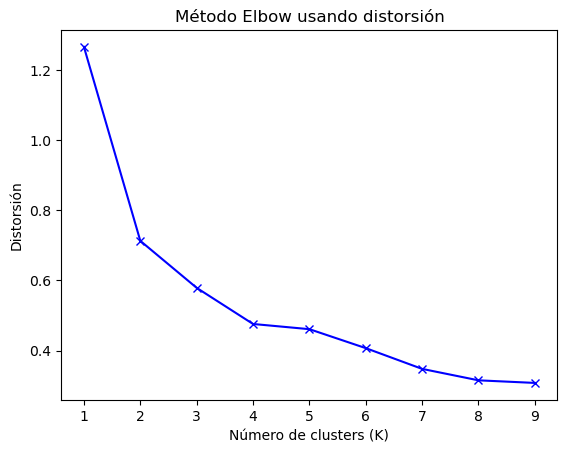

     5. Clusterización utilizando KMeans


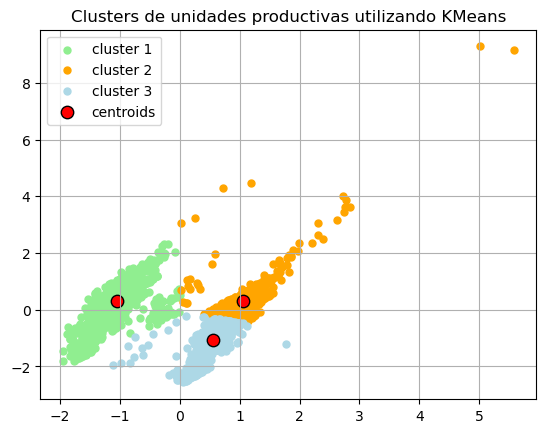

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan
kmeans,,,,,,,,,,,,,,,,,,,,,
1,987,987,987,987,987,987,987,987,987,987,...,987,987,987,987,987,987,987,987,987,987
0,1355,1355,1355,1355,1355,1355,1355,1355,1355,1355,...,1355,1355,1355,1355,1355,1355,1355,1355,1355,1355
2,672,672,672,672,672,672,672,672,672,672,...,672,672,672,672,672,672,672,672,672,672


kmeans                                                                0  \
index                                              mean    13237.377860   
                                                   median  13095.000000   
                                                   std      7801.349867   
EDAD                                               mean       42.024256   
                                                   median     42.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.114531   
RAZON_CREAR_NEGOCIO_nan                            mean        0.003690   
                                                   median      0.000000   
                                                   std         0.060656   

kmeans                                                                1  \
index                                              mean    13097.530902   
                                                   median  13218.000000   
                                                   std      7574.613744   
EDAD                                               mean       46.941345   
                                                   median     45.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.077770   
RAZON_CREAR_NEGOCIO_nan                            mean        0.002026   
                                                   median      0.000000   
                                                   std         0.044992   

kmeans                                                                2  
index                                              mean    13113.169643  
                                                   median  13273.000000  
                                                   std      7866.439984  
EDAD                                               mean       39.056029  
                                                   median     38.000000  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000  
                                                   std         0.115036  
RAZON_CREAR_NEGOCIO_nan                            mean        0.004464  
                                                   median      0.000000  
                                                   std         0.066716  

[120 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Agencia Pública de Empleo
index,,,,,,,,,,,,,,,,,,,,,
18,62.0000,4.000000e+06,3.0,No,10 años o más,0,1,Si y la renovó el último año,Me_gusta_este_producto_o_servic,1,...,0,0,0,0,0,0.550901,-1.061141,1.455167,87.382287,87.382287
20,52.0000,2.576009e+07,20.0,Si,10 años o más,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,0.550901,-1.061141,2.175549,81.042713,81.042713
22,55.0000,2.576009e+07,3.0,Si,Menos de un año,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,0.550901,-1.061141,1.177945,89.821925,89.821925
63,42.9806,2.576009e+07,6.0,Si,10 años o más,0,1,Si y la renovó el último año,Necesita_generar_ingresos_adici,1,...,0,0,0,0,0,0.550901,-1.061141,1.638917,85.765238,85.765238
77,25.0000,2.576009e+07,3.0,Si,De 5 a menos de 10 años,0,1,"Sí, pero desactualizada",Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,0.550901,-1.061141,0.845107,92.750995,92.750995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26301,30.0000,7.000000e+06,2.0,Si,De 1 a menos de 3 años,0,1,Si y la renovó el último año,Me gusta este producto o servic,2,...,0,0,0,0,0,0.550901,-1.061141,0.831394,92.871675,92.871675
26324,23.0000,2.576009e+07,1.0,No,Menos de un año,0,1,Si y la renovó el último año,Necesita_generar_ingresos_adici,2,...,0,0,0,0,0,0.550901,-1.061141,0.244753,98.034291,98.034291
26332,59.0000,7.000000e+06,3.0,No,De 3 a menos de 5 años,0,1,"Sí, pero desactualizada",Identificó una oportunidad en e,2,...,0,0,0,0,0,0.550901,-1.061141,0.295320,97.589285,97.589285


Programa: Pago por resultados o Empleo Joven
     1. Tipo de criterio: No excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,1832.000000,1.832000e+03,1832.000000,1832.000000,1832.000000
mean,42.813947,2.721994e+07,5.350437,0.454694,0.568231
std,12.050817,6.339417e+07,15.956539,0.498079,0.495458
min,19.000000,1.100000e+06,1.000000,0.000000,0.000000
25%,34.000000,1.200000e+07,2.000000,0.000000,0.000000
50%,42.640291,2.721994e+07,3.000000,0.000000,1.000000
75%,51.000000,2.721994e+07,4.000000,1.000000,1.000000
max,89.000000,1.850000e+09,378.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
Distorsión
1 : 1.2422242303276805
2 : 0.6589965130738975
3 : 0.6267927936809382
4 : 0.5053304543231224
5 : 0.42377268549950536
6 : 0.4151595915091134
7 : 0.35754941434226706
8 : 0.3135600705253716
9 : 0.28643466104578447


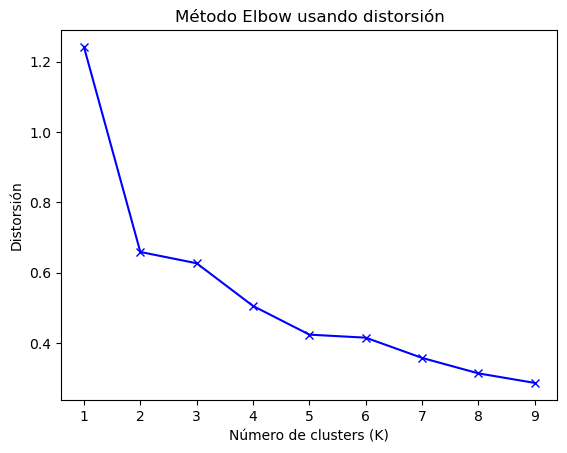

     5. Clusterización utilizando KMeans


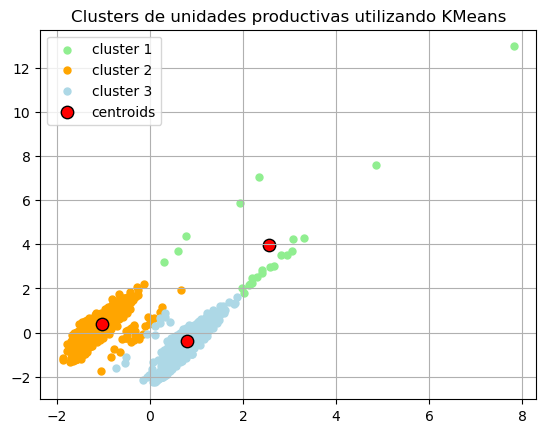

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,RAZON_CREAR_NEGOCIO_Las_personas_necesitan_de_mis_p,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan
kmeans,,,,,,,,,,,,,,,,,,,,,
2,991,991,991,991,991,991,991,991,991,991,...,991,991,991,991,991,991,991,991,991,991
1,818,818,818,818,818,818,818,818,818,818,...,818,818,818,818,818,818,818,818,818,818
0,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23


kmeans                                                                0  \
index                                              mean    13319.652174   
                                                   median  13947.000000   
                                                   std      7932.885911   
EDAD                                               mean       51.086012   
                                                   median     48.987052   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.000000   
RAZON_CREAR_NEGOCIO_nan                            mean        0.043478   
                                                   median      0.000000   
                                                   std         0.208514   

kmeans                                                                1  \
index                                              mean    13117.943765   
                                                   median  13189.500000   
                                                   std      7897.195660   
EDAD                                               mean       42.039396   
                                                   median     42.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.109956   
RAZON_CREAR_NEGOCIO_nan                            mean        0.002445   
                                                   median      0.000000   
                                                   std         0.049417   

kmeans                                                                2  
index                                              mean    12951.631685  
                                                   median  12977.000000  
                                                   std      7638.279798  
EDAD                                               mean       43.261298  
                                                   median     42.680208  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000  
                                                   std         0.083790  
RAZON_CREAR_NEGOCIO_nan                            mean        0.000000  
                                                   median      0.000000  
                                                   std         0.000000  

[114 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Pago por resultados o Empleo Joven
index,,,,,,,,,,,,,,,,,,,,,
22,55.000000,2.721994e+07,3.0,Si,Menos de un año,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,2,...,0,0,0,0,0,-1.02919,0.372512,2.051636,86.696180,86.696180
63,42.839875,2.721994e+07,6.0,Si,10 años o más,0,1,Si y la renovó el último año,Necesita_generar_ingresos_adici,2,...,0,0,0,0,0,-1.02919,0.372512,2.159385,85.995454,85.995454
64,49.000000,2.721994e+07,2.0,No,Menos de un año,0,1,No,Necesita_generar_ingresos_adici,2,...,0,0,0,0,0,-1.02919,0.372512,2.470285,83.973568,83.973568
77,25.000000,2.721994e+07,3.0,Si,De 5 a menos de 10 años,0,1,"Sí, pero desactualizada",Identificó_una_oportunidad_en_e,2,...,0,0,0,0,0,-1.02919,0.372512,1.935748,87.449839,87.449839
109,21.000000,3.000000e+06,1.0,No,Menos de un año,0,1,Si y la renovó el último año,Me gusta este producto o servic,2,...,0,0,0,0,0,-1.02919,0.372512,2.043304,86.750368,86.750368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21078,46.000000,2.721994e+07,93.0,Si,10 años o más,1,0,Si y la renovó el último año,Las_personas_necesitan_de_mis_p,0,...,0,0,0,0,0,-1.02919,0.372512,3.115531,79.777318,79.777318
22237,31.000000,6.000000e+08,94.0,Si,De 5 a menos de 10 años,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,0,0,0,0,0,-1.02919,0.372512,5.643496,63.337118,63.337118
25028,78.000000,2.721994e+07,52.0,Si,10 años o más,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,0,0,0,0,0,-1.02919,0.372512,3.365039,78.154680,78.154680


Programa: Bogotá Productiva Local
     1. Tipo de criterio: Excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,20228.000000,2.022800e+04,20228.000000,20228.000000,20228.000000
mean,46.299856,9.908204e+06,2.387928,0.473205,0.548497
std,12.673853,1.995300e+07,1.590234,0.499294,0.497655
min,19.000000,1.014000e+06,1.000000,0.000000,0.000000
25%,37.000000,6.000000e+06,1.000000,0.000000,0.000000
50%,46.000000,9.908204e+06,2.000000,0.000000,1.000000
75%,55.000000,9.908204e+06,3.000000,1.000000,1.000000
max,98.000000,1.700000e+09,9.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
Distorsión
1 : 1.2940182038542591
2 : 0.7824126186881148
3 : 0.6361926677792203
4 : 0.5208565191292027
5 : 0.4543854826365397
6 : 0.3970265281597048
7 : 0.36544680316314593
8 : 0.34058564258918345
9 : 0.32150336519769773


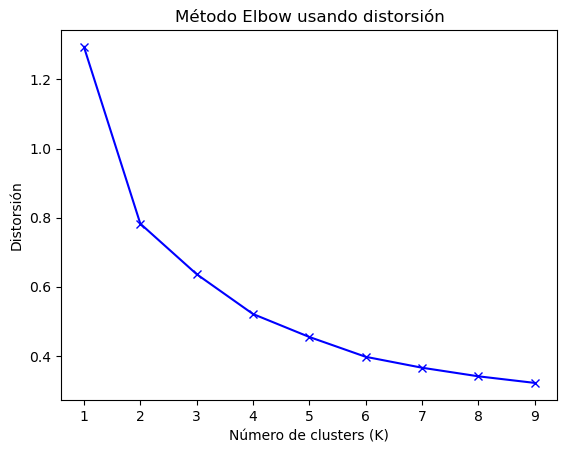

     5. Clusterización utilizando KMeans


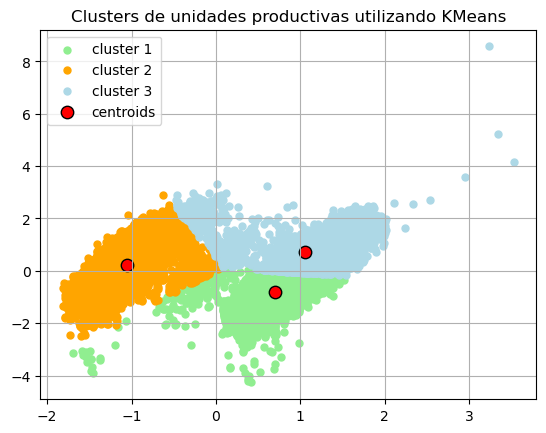

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan
kmeans,,,,,,,,,,,,,,,,,,,,,
1,9064,9064,9064,9064,9064,9064,9064,9064,9064,9064,...,9064,9064,9064,9064,9064,9064,9064,9064,9064,9064
0,6474,6474,6474,6474,6474,6474,6474,6474,6474,6474,...,6474,6474,6474,6474,6474,6474,6474,6474,6474,6474
2,4690,4690,4690,4690,4690,4690,4690,4690,4690,4690,...,4690,4690,4690,4690,4690,4690,4690,4690,4690,4690


kmeans                                                                0  \
index                                              mean    13177.292400   
                                                   median  13050.500000   
                                                   std      7574.921848   
EDAD                                               mean       50.967386   
                                                   median     50.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.128087   
RAZON_CREAR_NEGOCIO_nan                            mean        0.001236   
                                                   median      0.000000   
                                                   std         0.035134   

kmeans                                                                1  \
index                                              mean    13234.191637   
                                                   median  13275.500000   
                                                   std      7624.729138   
EDAD                                               mean       45.687103   
                                                   median     45.858246   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.123324   
RAZON_CREAR_NEGOCIO_nan                            mean        0.002317   
                                                   median      0.000000   
                                                   std         0.048081   

kmeans                                                                2  
index                                              mean    13439.387207  
                                                   median  13462.000000  
                                                   std      7606.718775  
EDAD                                               mean       41.041094  
                                                   median     40.000000  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000  
                                                   std         0.091967  
RAZON_CREAR_NEGOCIO_nan                            mean        0.001066  
                                                   median      0.000000  
                                                   std         0.032637  

[117 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Bogotá Productiva Local
index,,,,,,,,,,,,,,,,,,,,,
0,33.0,9.908204e+06,2.0,No,De 1 a menos de 3 años,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,0.699745,-0.807702,2.400220,75.335354,75.335354
2,62.0,6.000000e+06,2.0,No,De 5 a menos de 10 años,1,0,Si y la renovó el último año,Identificó una oportunidad en e,1,...,0,0,0,0,0,0.699745,-0.807702,1.781311,81.712282,81.712282
3,54.0,9.908204e+06,2.0,No,De 3 a menos de 5 años,1,0,Si y la renovó el último año,No_tenía_trabajo,1,...,1,0,0,0,0,0.699745,-0.807702,1.989125,79.571067,79.571067
6,45.0,2.500000e+06,2.0,Si,De 1 a menos de 3 años,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,0.699745,-0.807702,2.704217,72.203111,72.203111
9,50.0,1.200000e+06,1.0,No,De 3 a menos de 5 años,1,0,Si y la renovó el último año,No_tenía_trabajo,1,...,1,0,0,0,0,0.699745,-0.807702,2.072523,78.711777,78.711777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26405,41.0,9.908204e+06,1.0,Si,De 3 a menos de 5 años,0,1,"Sí, pero desactualizada",Identificó_una_oportunidad_en_e,2,...,0,0,0,0,0,0.699745,-0.807702,1.310613,86.562116,86.562116
26407,59.0,9.908204e+06,7.0,No,10 años o más,0,1,Si y la renovó el último año,Me_gusta_este_producto_o_servic,2,...,0,0,0,0,0,0.699745,-0.807702,1.191733,87.786996,87.786996
26415,37.0,9.908204e+06,9.0,Si,10 años o más,1,1,Si y la renovó el último año,Identificó una oportunidad en e,2,...,0,0,0,0,0,0.699745,-0.807702,2.772412,71.500470,71.500470


Programa: Camino a la inclusión financiera
     1. Tipo de criterio: No excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,8980.000000,8.980000e+03,8980.000000,8980.000000,8980.000000
mean,46.467055,9.165035e+06,2.344353,0.508463,0.548552
std,13.613539,2.404168e+07,5.879774,0.499956,0.497665
min,-5.437207,1.000008e+06,1.000000,0.000000,0.000000
25%,36.000000,4.000000e+06,1.000000,0.000000,0.000000
50%,46.441106,9.165035e+06,2.000000,1.000000,1.000000
75%,56.000000,9.165035e+06,2.000000,1.000000,1.000000
max,96.000000,1.700000e+09,380.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
Distorsión
1 : 1.2788401138512573
2 : 0.7687219114326365
3 : 0.6274383439645291
4 : 0.5074578586920659
5 : 0.45084969723569646
6 : 0.402390955845698
7 : 0.36650236709701933
8 : 0.36372357113090614
9 : 0.3357281368114016


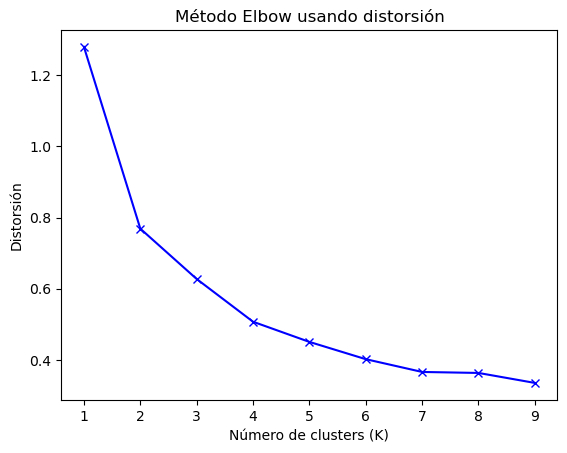

     5. Clusterización utilizando KMeans


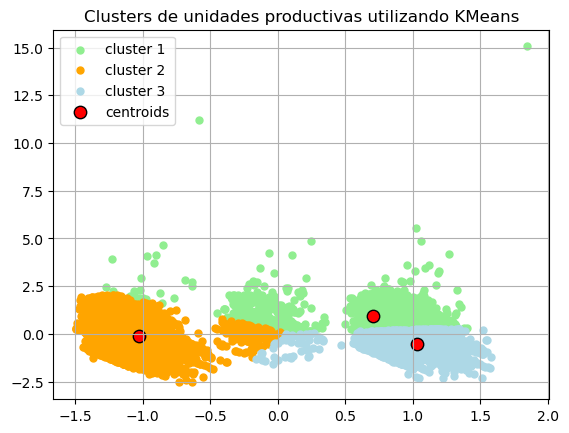

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan
kmeans,,,,,,,,,,,,,,,,,,,,,
1,4161,4161,4161,4161,4161,4161,4161,4161,4161,4161,...,4161,4161,4161,4161,4161,4161,4161,4161,4161,4161
0,2091,2091,2091,2091,2091,2091,2091,2091,2091,2091,...,2091,2091,2091,2091,2091,2091,2091,2091,2091,2091
2,2728,2728,2728,2728,2728,2728,2728,2728,2728,2728,...,2728,2728,2728,2728,2728,2728,2728,2728,2728,2728


kmeans                                                                0  \
index                                              mean    13299.155428   
                                                   median  13135.000000   
                                                   std      7554.824806   
EDAD                                               mean       39.962635   
                                                   median     40.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.195286   
RAZON_CREAR_NEGOCIO_nan                            mean        0.000000   
                                                   median      0.000000   
                                                   std         0.000000   

kmeans                                                                1  \
index                                              mean    13159.407835   
                                                   median  13285.000000   
                                                   std      7684.386266   
EDAD                                               mean       45.567867   
                                                   median     46.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.162560   
RAZON_CREAR_NEGOCIO_nan                            mean        0.000481   
                                                   median      0.000000   
                                                   std         0.021921   

kmeans                                                                2  
index                                              mean    13228.487537  
                                                   median  13286.000000  
                                                   std      7618.636445  
EDAD                                               mean       52.824188  
                                                   median     53.000000  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000  
                                                   std         0.134161  
RAZON_CREAR_NEGOCIO_nan                            mean        0.000367  
                                                   median      0.000000  
                                                   std         0.019146  

[117 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Camino a la inclusión financiera
index,,,,,,,,,,,,,,,,,,,,,
5,36.0,9.165035e+06,2.0,Si,Menos de un año,1,0,Si y la renovó el último año,Identificó una oportunidad en e,1,...,0,0,0,0,0,1.026749,-0.542351,2.970511,81.009715,81.009715
7,66.0,9.165035e+06,1.0,No,Menos de un año,1,0,Si y la renovó el último año,Me_gusta_este_producto_o_servic,1,...,0,0,0,0,0,1.026749,-0.542351,1.891172,87.921593,87.921593
15,60.0,9.165035e+06,2.0,No,10 años o más,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,1.026749,-0.542351,1.711767,89.070469,89.070469
27,48.0,9.165035e+06,3.0,No,10 años o más,1,0,No,Me gusta este producto o servic,1,...,0,0,0,0,0,1.026749,-0.542351,1.873501,88.034754,88.034754
32,25.0,5.000000e+06,1.0,No,Menos de un año,1,0,No,Necesitaba generar ingresos adi,1,...,0,0,0,0,0,1.026749,-0.542351,2.415915,84.561238,84.561238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26372,55.0,9.165035e+06,1.0,No,10 años o más,0,1,"Sí, pero desactualizada",No tenía trabajo,2,...,0,0,0,0,0,1.026749,-0.542351,0.169759,98.945189,98.945189
26373,42.0,9.165035e+06,1.0,No,De 5 a menos de 10 años,0,1,"Sí, pero desactualizada",No_tenía_trabajo,2,...,1,0,0,0,0,1.026749,-0.542351,0.127531,99.215607,99.215607
26384,55.0,9.165035e+06,1.0,No,De 5 a menos de 10 años,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,2,...,0,0,0,0,0,1.026749,-0.542351,0.510686,96.761960,96.761960


Programa: Corazon Productivo
     1. Tipo de criterio: Excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,14.000000,1.400000e+01,14.000000,14.000000,14.000000
mean,52.199999,4.350000e+07,18.214286,0.214286,0.785714
std,7.293833,1.431648e+07,7.607472,0.425815,0.425815
min,41.000000,7.000000e+06,10.000000,0.000000,0.000000
25%,50.250000,4.350000e+07,11.000000,0.000000,1.000000
50%,52.199961,4.350000e+07,18.000000,0.000000,1.000000
75%,55.050011,4.350000e+07,24.750000,0.000000,1.000000
max,68.000000,8.000000e+07,31.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
Distorsión
1 : 1.4599753829230089
2 : 1.0038994466723317
3 : 0.6727800603218235
4 : 0.4754193444778405
5 : 0.35921875999124586
6 : 0.30701308678759337
7 : 0.255581455239318
8 : 0.20934199569539863
9 : 0.15846522410592936


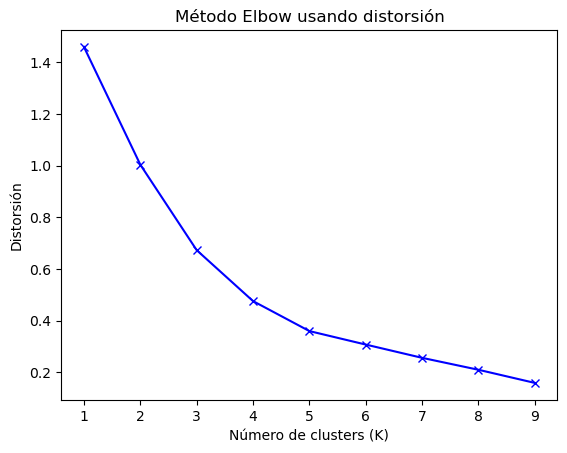

     5. Clusterización utilizando KMeans


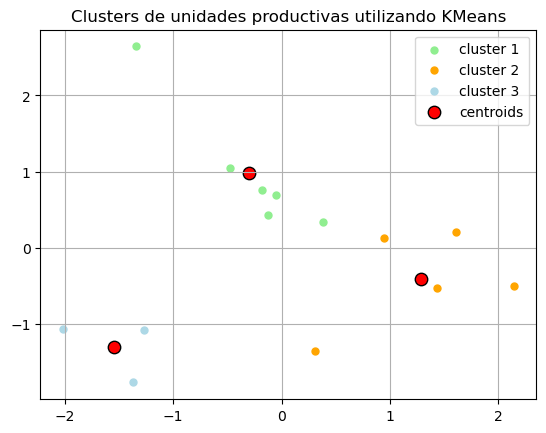

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,PROPIETARIOS_MUJERES_dummy_0,PROPIETARIOS_MUJERES_dummy_1,PROPIETARIOS_HOMBRES_dummy_0,PROPIETARIOS_HOMBRES_dummy_1,R_MERCANTIL_Si y la renovó el último año,RAZON_CREAR_NEGOCIO_Identificó_una_oportunidad_en_e,RAZON_CREAR_NEGOCIO_Las_personas_necesitan_de_mis_p,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_No_tenía_trabajo
kmeans,,,,,,,,,,,,,,,,,,,,,
2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
0,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
1,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


kmeans                                                                0  \
index                                              mean    11054.333333   
                                                   median   9861.000000   
                                                   std      8128.942555   
EDAD                                               mean       47.733320   
                                                   median     47.599979   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_a... median      0.000000   
                                                   std         0.000000   
RAZON_CREAR_NEGOCIO_No_tenía_trabajo               mean        0.166667   
                                                   median      0.000000   
                                                   std         0.408248   

kmeans                                                                1  \
index                                              mean    17796.000000   
                                                   median  18681.000000   
                                                   std      5733.647094   
EDAD                                               mean       56.240008   
                                                   median     52.200042   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_a... median      0.000000   
                                                   std         0.547723   
RAZON_CREAR_NEGOCIO_No_tenía_trabajo               mean        0.000000   
                                                   median      0.000000   
                                                   std         0.000000   

kmeans                                                                2  
index                                              mean    14603.333333  
                                                   median  17163.000000  
                                                   std     12528.174262  
EDAD                                               mean       54.400006  
                                                   median     52.200018  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_a... median      0.000000  
                                                   std         0.000000  
RAZON_CREAR_NEGOCIO_No_tenía_trabajo               mean        0.000000  
                                                   median      0.000000  
                                                   std         0.000000  

[81 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_Identificó_una_oportunidad_en_e,RAZON_CREAR_NEGOCIO_Las_personas_necesitan_de_mis_p,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Corazon Productivo
index,,,,,,,,,,,,,,,,,,,,,
993,59.000000,4.350000e+07,31.0,Si,De 5 a menos de 10 años,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,2,...,1,0,0,0,0,1.290203,-0.404985,3.374892,17.033987,17.033987
17163,52.200018,4.350000e+07,15.0,Si,De 5 a menos de 10 años,1,0,Si y la renovó el último año,Me_gusta_este_producto_o_servic,2,...,0,0,1,0,0,1.290203,-0.404985,2.984233,27.205546,27.205546
25654,52.000000,4.350000e+07,23.0,Si,10 años o más,1,0,Si y la renovó el último año,Me_gusta_este_producto_o_servic,2,...,0,0,1,0,0,1.290203,-0.404985,2.644328,36.055631,36.055631
1556,42.000000,4.350000e+07,21.0,Si,De 3 a menos de 5 años,0,1,Si y la renovó el último año,Me_gusta_este_producto_o_servic,0,...,0,0,1,0,0,1.290203,-0.404985,1.649874,61.948143,61.948143
4133,52.199958,4.350000e+07,25.0,Si,10 años o más,0,1,Si y la renovó el último año,No_tenía_trabajo,0,...,0,0,0,0,1,1.290203,-0.404985,1.729841,59.866030,59.866030
7483,56.000000,4.350000e+07,11.0,Si,10 años o más,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,1,0,0,0,0,1.290203,-0.404985,1.178528,74.220539,74.220539
12239,41.000000,8.000000e+07,27.0,Si,Menos de un año,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,1,0,0,0,0,1.290203,-0.404985,4.029117,0.000000,0.000000
19658,43.000000,4.350000e+07,25.0,Si,10 años o más,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,1,0,0,0,0,1.290203,-0.404985,2.285535,45.397483,45.397483
21257,52.199964,4.350000e+07,24.0,Si,De 3 a menos de 5 años,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,1,0,0,0,0,1.290203,-0.404985,1.880629,55.939982,55.939982


Programa: Bogotá Alto Impacto
     1. Tipo de criterio: Excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,15525.000000,1.552500e+04,15525.000000,15525.000000,15525.000000
mean,45.796832,1.741137e+07,4.088757,0.465378,0.558776
std,12.276403,3.981166e+07,16.168001,0.498816,0.496549
min,19.000000,1.014000e+06,1.000000,0.000000,0.000000
25%,37.000000,8.400000e+06,1.000000,0.000000,0.000000
50%,45.794670,1.741137e+07,2.000000,0.000000,1.000000
75%,54.000000,1.741137e+07,4.000000,1.000000,1.000000
max,98.000000,1.850000e+09,1000.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
Distorsión
1 : 1.2733507838147768
2 : 0.7758910043204582
3 : 0.622792936155687
4 : 0.5076540514709086
5 : 0.43910480610996416
6 : 0.38090100964098483
7 : 0.3526927956738275
8 : 0.32826839563625587
9 : 0.30962527050402805


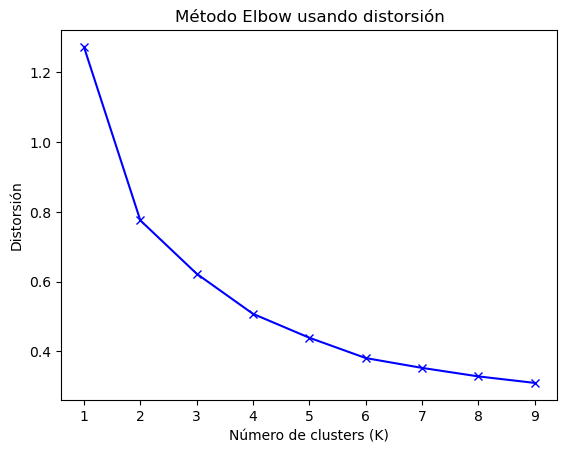

     5. Clusterización utilizando KMeans


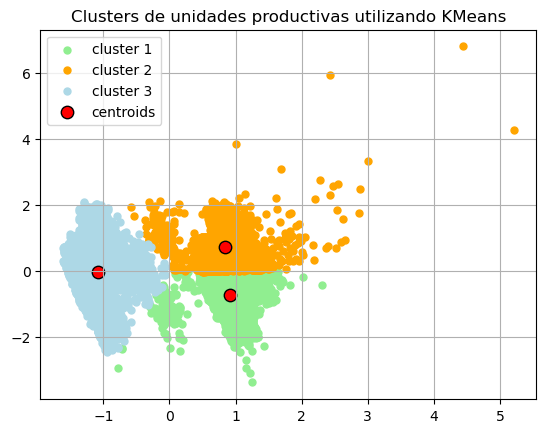

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan
kmeans,,,,,,,,,,,,,,,,,,,,,
2,6959,6959,6959,6959,6959,6959,6959,6959,6959,6959,...,6959,6959,6959,6959,6959,6959,6959,6959,6959,6959
1,4484,4484,4484,4484,4484,4484,4484,4484,4484,4484,...,4484,4484,4484,4484,4484,4484,4484,4484,4484,4484
0,4082,4082,4082,4082,4082,4082,4082,4082,4082,4082,...,4082,4082,4082,4082,4082,4082,4082,4082,4082,4082


kmeans                                                                0  \
index                                              mean    13179.915483   
                                                   median  12918.000000   
                                                   std      7507.628041   
EDAD                                               mean       53.986330   
                                                   median     54.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.129840   
RAZON_CREAR_NEGOCIO_nan                            mean        0.001960   
                                                   median      0.000000   
                                                   std         0.044232   

kmeans                                                                1  \
index                                              mean    13222.312667   
                                                   median  13343.500000   
                                                   std      7639.070447   
EDAD                                               mean       39.573357   
                                                   median     40.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.085481   
RAZON_CREAR_NEGOCIO_nan                            mean        0.000669   
                                                   median      0.000000   
                                                   std         0.025860   

kmeans                                                                2  
index                                              mean    13287.463572  
                                                   median  13366.000000  
                                                   std      7635.625298  
EDAD                                               mean       45.003117  
                                                   median     45.700743  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000  
                                                   std         0.122484  
RAZON_CREAR_NEGOCIO_nan                            mean        0.002587  
                                                   median      0.000000  
                                                   std         0.050796  

[108 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Bogotá Alto Impacto
index,,,,,,,,,,,,,,,,,,,,,
0,33.000000,1.741137e+07,2.0,No,De 1 a menos de 3 años,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,2,...,0,0,0,0,0,-1.077508,-0.031853,0.642584,92.804165,92.804165
2,62.000000,6.000000e+06,2.0,No,De 5 a menos de 10 años,1,0,Si y la renovó el último año,Identificó una oportunidad en e,2,...,0,0,0,0,0,-1.077508,-0.031853,0.899708,89.872085,89.872085
3,54.000000,1.741137e+07,2.0,No,De 3 a menos de 5 años,1,0,Si y la renovó el último año,No_tenía_trabajo,2,...,1,0,0,0,0,-1.077508,-0.031853,0.517355,94.232201,94.232201
6,45.000000,2.500000e+06,2.0,Si,De 1 a menos de 3 años,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,2,...,0,0,0,0,0,-1.077508,-0.031853,1.219292,86.227747,86.227747
9,50.000000,1.200000e+06,1.0,No,De 3 a menos de 5 años,1,0,Si y la renovó el último año,No_tenía_trabajo,2,...,1,0,0,0,0,-1.077508,-0.031853,0.458386,94.904642,94.904642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26384,55.000000,1.741137e+07,1.0,No,De 5 a menos de 10 años,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,0,0,0,0,0,-1.077508,-0.031853,2.058070,76.662840,76.662840
26387,60.000000,1.741137e+07,2.0,No,10 años o más,1,1,Si y la renovó el último año,Por tradición familiar o lo her,0,...,0,0,0,1,0,-1.077508,-0.031853,1.718373,80.536536,80.536536
26402,65.000000,1.741137e+07,3.0,Si,10 años o más,0,1,Si y la renovó el último año,Me_gusta_este_producto_o_servic,0,...,0,0,0,0,0,-1.077508,-0.031853,2.433365,72.383215,72.383215


Programa: Hecho en Bogotá
     1. Tipo de criterio: Excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,374.000000,3.740000e+02,374.000000,374.000000,374.000000
mean,42.810241,1.425440e+07,3.500000,0.532086,0.596257
std,10.749574,2.621048e+07,6.342228,0.499638,0.491304
min,20.000000,1.100000e+06,1.000000,0.000000,0.000000
25%,35.000000,4.000000e+06,1.000000,0.000000,0.000000
50%,42.460961,1.200000e+07,2.000000,1.000000,1.000000
75%,50.000000,1.425440e+07,3.000000,1.000000,1.000000
max,77.000000,3.500000e+08,99.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
Distorsión
1 : 1.236546018202649
2 : 0.7515943492210292
3 : 0.6743780420391147
4 : 0.5658613038845592
5 : 0.5168516041202087
6 : 0.4801093650366625
7 : 0.42896841158234517
8 : 0.3830943539263825
9 : 0.3568774920670207


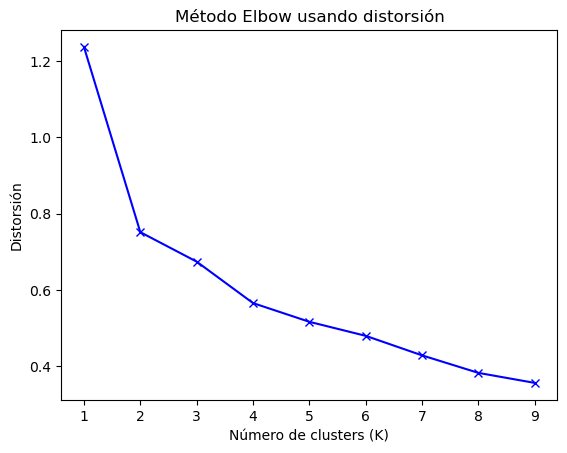

     5. Clusterización utilizando KMeans


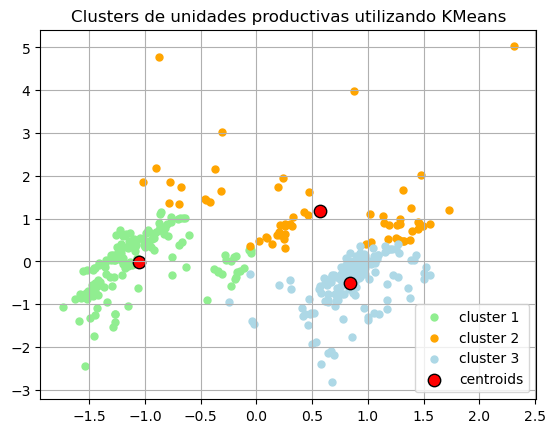

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,PROPIETARIOS_HOMBRES_dummy_1,R_MERCANTIL_No,R_MERCANTIL_Si y la renovó el último año,"R_MERCANTIL_Sí, pero desactualizada",RAZON_CREAR_NEGOCIO_Identificó una oportunidad en e,RAZON_CREAR_NEGOCIO_Las personas necesitan de mis p,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her
kmeans,,,,,,,,,,,,,,,,,,,,,
2,152,152,152,152,152,152,152,152,152,152,...,152,152,152,152,152,152,152,152,152,152
0,157,157,157,157,157,157,157,157,157,157,...,157,157,157,157,157,157,157,157,157,157
1,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65


kmeans                                                                0  \
index                                              mean    13542.343949   
                                                   median  15030.000000   
                                                   std      7651.015358   
EDAD                                               mean       39.463239   
                                                   median     38.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_No tenía trabajo               median      0.000000   
                                                   std         0.319618   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... mean        0.044586   
                                                   median      0.000000   
                                                   std         0.207053   

kmeans                                                                1  \
index                                              mean    14039.261538   
                                                   median  15167.000000   
                                                   std      7659.148489   
EDAD                                               mean       53.035639   
                                                   median     52.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_No tenía trabajo               median      0.000000   
                                                   std         0.000000   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... mean        0.046154   
                                                   median      0.000000   
                                                   std         0.211451   

kmeans                                                                2  
index                                              mean    13279.302632  
                                                   median  12633.500000  
                                                   std      7956.719634  
EDAD                                               mean       41.894639  
                                                   median     41.000000  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_No tenía trabajo               median      0.000000  
                                                   std         0.299223  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... mean        0.059211  
                                                   median      0.000000  
                                                   std         0.236799  

[84 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_Las personas necesitan de mis p,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Hecho en Bogotá
index,,,,,,,,,,,,,,,,,,,,,
125,25.000000,2.000000e+06,3.0,Si,De 3 a menos de 5 años,0,1,"Sí, pero desactualizada",Necesitaba generar ingresos adi,2,...,0,0,1,0,0,0.843371,-0.49712,1.908065,66.841349,66.841349
463,36.000000,1.425440e+07,1.0,Si,De 5 a menos de 10 años,0,1,No,Necesitaba generar ingresos adi,2,...,0,0,1,0,0,0.843371,-0.49712,0.559622,90.546730,90.546730
524,52.000000,3.000000e+06,4.0,Si,De 3 a menos de 5 años,1,1,No,No tenía trabajo,2,...,0,0,0,1,0,0.843371,-0.49712,1.181381,79.616314,79.616314
812,42.523036,5.000000e+06,2.0,Si,De 3 a menos de 5 años,0,1,Si y la renovó el último año,Identificó una oportunidad en e,2,...,0,0,0,0,0,0.843371,-0.49712,0.154045,97.676695,97.676695
931,48.000000,2.000000e+06,3.0,Si,De 3 a menos de 5 años,1,1,"Sí, pero desactualizada",Necesitaba generar ingresos adi,2,...,0,0,1,0,0,0.843371,-0.49712,1.295201,77.615387,77.615387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25476,77.000000,1.425440e+07,2.0,Si,10 años o más,0,1,Si y la renovó el último año,Identificó una oportunidad en e,1,...,0,0,0,0,0,0.843371,-0.49712,1.919660,66.637509,66.637509
25781,53.000000,1.500000e+07,2.0,Si,10 años o más,1,1,Si y la renovó el último año,Necesitaba generar ingresos adi,1,...,0,0,1,0,0,0.843371,-0.49712,1.182534,79.596037,79.596037
25957,54.000000,1.425440e+07,6.0,Si,De 5 a menos de 10 años,1,1,Si y la renovó el último año,Necesitaba generar ingresos adi,1,...,0,0,1,0,0,0.843371,-0.49712,1.275400,77.963475,77.963475


In [9]:
np.random.seed(0)

for nombre_programa in list_programas:
   x_res = triage.triage(nombre_programa, df_tropa, cp.features, cp.features_cont, 
                 cp.features_cat, mice_imputer, famd)
   df_tropa_contacto = df_tropa_contacto.join(x_res[nombre_programa], lsuffix='_caller', rsuffix='_other')

### Guardar archivo de priorización

Este es el archivo que se le entrega a tropa para segundas visitas.

In [10]:
df_tropa_contacto.to_csv(output_path + 'priorizacion.csv', index = False)

In [11]:
#df_tropa_contacto.to_excel(output_path + 'priorizacion.xlsx', index = False)

In [12]:
df_tropa_contacto

,ObjectID,LOCALIDAD,UPZ,DIRECCION_COMPLETA,COMPLEMENTO,NOMBRE_ENCUESTADO,RAZON_SOCIAL,NOMBRE_COMERCIAL,TELEFONOS,CORREOS,...,NUMERO_ID_PROPIETARIO,TIPO_ID_NEGOCIO,NUMERO_ID_NEGOCIO,Agencia Pública de Empleo,Pago por resultados o Empleo Joven,Bogotá Productiva Local,Camino a la inclusión financiera,Corazon Productivo,Bogotá Alto Impacto,Hecho en Bogotá
0,916337266631,Barrios_Unidos,Doce_De_Octubre,DIRECCION_COMPLETA_916337266631,COMPLEMENTO_916337266631,NOMBRE_ENCUESTADO_916337266631,RAZON_SOCIAL_916337266631,NOMBRE_COMERCIAL_916337266631,TELEFONOS_916337266631,CORREOS_916337266631,...,NUMERO_ID_PROPIETARIO_916337266631,TIPO_ID_NEGOCIO_916337266631,NUMERO_ID_NEGOCIO_916337266631,NaN,NaN,75.335354,NaN,NaN,92.804165,NaN
1,4655437695,Puente_Aranda,San_Rafael,DIRECCION_COMPLETA_4655437695,COMPLEMENTO_4655437695,NOMBRE_ENCUESTADO_4655437695,RAZON_SOCIAL_4655437695,NOMBRE_COMERCIAL_4655437695,TELEFONOS_4655437695,CORREOS_4655437695,...,NUMERO_ID_PROPIETARIO_4655437695,TIPO_ID_NEGOCIO_4655437695,NUMERO_ID_NEGOCIO_4655437695,NaN,NaN,NaN,NaN,NaN,70.984749,NaN
2,527770828607,San Cristóbal,La Gloria,DIRECCION_COMPLETA_527770828607,COMPLEMENTO_527770828607,NOMBRE_ENCUESTADO_527770828607,RAZON_SOCIAL_527770828607,NOMBRE_COMERCIAL_527770828607,TELEFONOS_527770828607,CORREOS_527770828607,...,NUMERO_ID_PROPIETARIO_527770828607,TIPO_ID_NEGOCIO_527770828607,NUMERO_ID_NEGOCIO_527770828607,NaN,NaN,81.712282,NaN,NaN,89.872085,NaN
3,177541772732,Bosa,Tintal_Sur,DIRECCION_COMPLETA_177541772732,COMPLEMENTO_177541772732,NOMBRE_ENCUESTADO_177541772732,RAZON_SOCIAL_177541772732,NOMBRE_COMERCIAL_177541772732,TELEFONOS_177541772732,CORREOS_177541772732,...,NUMERO_ID_PROPIETARIO_177541772732,TIPO_ID_NEGOCIO_177541772732,NUMERO_ID_NEGOCIO_177541772732,NaN,NaN,79.571067,NaN,NaN,94.232201,NaN
4,268161061500,Los_Mártires,La_Sabana,DIRECCION_COMPLETA_268161061500,COMPLEMENTO_268161061500,NOMBRE_ENCUESTADO_268161061500,RAZON_SOCIAL_268161061500,NOMBRE_COMERCIAL_268161061500,TELEFONOS_268161061500,CORREOS_268161061500,...,NUMERO_ID_PROPIETARIO_268161061500,TIPO_ID_NEGOCIO_268161061500,NUMERO_ID_NEGOCIO_268161061500,NaN,NaN,97.751266,NaN,NaN,81.507421,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26415,111710997233,Bosa,Bosa Central,DIRECCION_COMPLETA_111710997233,COMPLEMENTO_111710997233,NOMBRE_ENCUESTADO_111710997233,RAZON_SOCIAL_111710997233,NOMBRE_COMERCIAL_111710997233,TELEFONOS_111710997233,CORREOS_111710997233,...,NUMERO_ID_PROPIETARIO_111710997233,TIPO_ID_NEGOCIO_111710997233,NUMERO_ID_NEGOCIO_111710997233,NaN,NaN,71.500470,83.458046,NaN,85.354612,NaN
26416,325189346857,Puente_Aranda,San_Rafael,DIRECCION_COMPLETA_325189346857,COMPLEMENTO_325189346857,NOMBRE_ENCUESTADO_325189346857,RAZON_SOCIAL_325189346857,NOMBRE_COMERCIAL_325189346857,TELEFONOS_325189346857,CORREOS_325189346857,...,NUMERO_ID_PROPIETARIO_325189346857,TIPO_ID_NEGOCIO_325189346857,NUMERO_ID_NEGOCIO_325189346857,NaN,NaN,76.939704,NaN,NaN,95.420224,NaN
26417,822345553191,Santa_Fe,Las_Nieves,DIRECCION_COMPLETA_822345553191,COMPLEMENTO_822345553191,NOMBRE_ENCUESTADO_822345553191,RAZON_SOCIAL_822345553191,NOMBRE_COMERCIAL_822345553191,TELEFONOS_822345553191,CORREOS_822345553191,...,NUMERO_ID_PROPIETARIO_822345553191,TIPO_ID_NEGOCIO_822345553191,NUMERO_ID_NEGOCIO_822345553191,NaN,NaN,82.640031,NaN,NaN,72.829034,NaN
26418,350153946965,Barrios_Unidos,Los_Andes,DIRECCION_COMPLETA_350153946965,COMPLEMENTO_350153946965,NOMBRE_ENCUESTADO_350153946965,RAZON_SOCIAL_350153946965,NOMBRE_COMERCIAL_350153946965,TELEFONOS_350153946965,CORREOS_350153946965,...,NUMERO_ID_PROPIETARIO_350153946965,TIPO_ID_NEGOCIO_350153946965,NUMERO_ID_NEGOCIO_350153946965,NaN,NaN,75.814933,NaN,NaN,97.576011,NaN
